#  Exracting atom Position with LLM's : Electron Microscopy and atomGPT

In [1]:
import sys
sys.path.append("/nfs/home/upratius/scratch_i24/projects/pyAutoMic/TEM/stemOrchestrator/notebooks/atomGPT_related/AS-1.14/")
sys.path.append("/nfs/home/upratius/scratch_i24/projects/pyAutoMic/TEM/stemOrchestrator/")

In [2]:
from stemOrchestrator.logging_config   import setup_logging
data_folder  = "."
out_path = data_folder
setup_logging(out_path=out_path) 

In [3]:
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
import logging
plot = plt
from typing import Dict

In [4]:
import yaml

# Load the YAML file
with open("credential.yaml", "r") as f:
    cred = yaml.safe_load(f)

api_key = cred["atomGPT-api-key"]

# Check imports
import sys
sys.path.append("atomgpt/")
import atomgpt
import os
os.environ.pop('MPLBACKEND', None)  # Remove the invalid backend
import matplotlib
matplotlib.use('Agg')  # Use a compatible backend
import matplotlib.pyplot as plt
os.chdir('atomgpt')


In [5]:
import os
import json
from pathlib import Path

ip = "10.46.217.241"
port = 9095

# ip = "10.46.217.242"
# port = 9090


# if not ip or not port:
#     secret_path = Path("/nfs/home/upratius/scratch_i24/projects/pyAutoMic/TEM/stemOrchestrator/config_secret.json")
#     if secret_path.exists():
#         with open(secret_path, "r") as f:
#             secret = json.load(f)
#             ip = ip or secret.get("ip_TF")
#             port = port or secret.get("port_TF")



config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 10e-6,  # micro-seconds per pixel
    "haadf_resolution": 512, # square
    "out_path": "."
}

In [6]:

ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]
haadf_resolution = config["haadf_resolution"]



microscope = TemMicroscopeClient()
microscope.connect(ip, port = port)# 7521 on velox  computer
# microscope.connect( port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope)

# put beam shift to 0,0
# tf_acquisition.move_beam_shift_positon([0, 0])


Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
2025-10-16 15:23:49,803 - INFO - Starting microscope initialization...
2025-10-16 15:23:49,849 - INFO - CETA camera initialized
2025-10-16 15:23:49,852 - INFO - HAADF detector initialized
2025-10-16 15:23:49,858 - INFO - Microscope initialization completed successfully


2025-10-16 15:25:29,813 - INFO - Acquiring HAADF image.
2025-10-16 15:25:29,813 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-10-16 15:25:29,815 - INFO - DONE -- beam UNblanking
2025-10-16 15:25:33,283 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-10-16 15:25:33,299 - INFO - DONE -- beam blanking
2025-10-16 15:25:33,330 - INFO - saving HAADF image as TF which has all the metadata..also returning an array
2025-10-16 15:25:33,330 - INFO - Done: Acquiring HAADF image - beam is blanked after acquisition - HAADF det is inserted


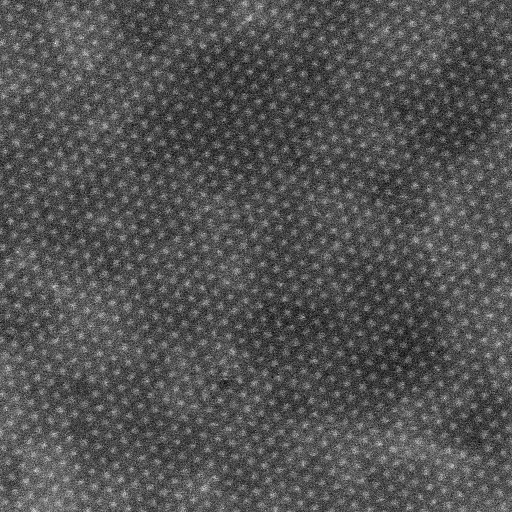

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Assume these exist:
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(exposure=10e-6, resolution=512)

# Normalize the image for saving (important for float data)
img = haadf_np_array - np.min(haadf_np_array)
img = img / np.max(img)
img_uint8 = (img * 255).astype(np.uint8)

# Save as PNG (same name but .png)
png_name = haadf_tiff_name.replace('.tiff', '.png')
Image.fromarray(img_uint8).save(png_name)

import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import Image
#Input Image of FeTe from: https://www.nature.com/articles/s41467-020-17253-x
Image(png_name)


AtomGPT: OpenAI failed to import - ignoring for now.
AtomGPT 2025.5.7: Fast Mllama patching. Transformers: 4.51.3.
NVIDIA H100 80GB HBM3. Num GPUs = 4. Max memory: 79.209 GB. Platform: Linux.
Torch: 2.7.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.0
Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]


🔍 Running evaluation on samples...
pred_atoms System
1.0
3.2 0.0 0.0
-1.6 2.77128 0.0
0.0 0.0 18.16
W S 
1 2 
direct
0.0 0.0 0.5 W
0.667 0.333 0.587 S
0.667 0.333 0.413 S





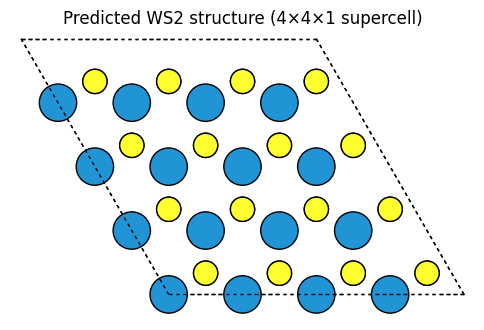

In [10]:
import subprocess
import matplotlib.pyplot as plt
from ase.io import read
from ase.visualize.plot import plot_atoms
from io import StringIO

# Run the AtomGPT command and capture its output
cmd = [
    "python", "atomgpt/inverse_models/inverse_vision_predict.py",
    "--image_path", png_name,
    "--formula", "WS2"
]

result = subprocess.run(cmd, capture_output=True, text=True)

# Print the entire stdout so you can inspect it
print(result.stdout)

# Extract the POSCAR-like output block
import re
pattern = r"(pred_atoms[\s\S]+?)(?:CPU times|$)"
match = re.search(pattern, result.stdout)
if not match:
    raise ValueError("POSCAR-like output not found in model output")

poscar_str = match.group(1).strip()

# Visualize
atoms = read(StringIO(poscar_str), format='vasp')
atoms = atoms * (4, 4, 1)  # replicate supercell for clarity

fig, ax = plt.subplots(figsize=(6, 6))
plot_atoms(atoms, ax, radii=0.5, rotation=('0x, 0y, 0z'))
plt.title("Predicted WS2 structure (4×4×1 supercell)")
plt.axis('off')
plt.show()


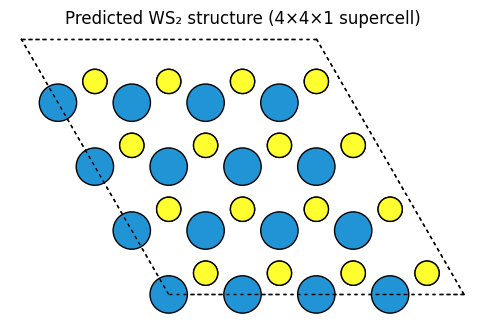

In [27]:
# Visualize
atoms = read(StringIO(poscar_str), format='vasp')
atoms = atoms * (4, 4, 1)  # replicate supercell for clarity

fig, ax = plt.subplots(figsize=(6, 6))
plot_atoms(atoms, ax, radii=0.5, rotation=('0x, 0y, 0z'))
plt.title("Predicted WS₂ structure (4×4×1 supercell)")
plt.axis('off')
plt.show()

In [19]:
# %%time
# !python atomgpt/inverse_models/inverse_vision_predict.py --image_path "$png_name" --formula WS2


AtomGPT: OpenAI failed to import - ignoring for now.
AtomGPT 2025.5.7: Fast Mllama patching. Transformers: 4.51.3.
NVIDIA H100 80GB HBM3. Num GPUs = 4. Max memory: 79.209 GB. Platform: Linux.
Torch: 2.7.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.0
Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:05<00:00,  2.76s/it]

🔍 Running evaluation on samples...
pred_atoms System
1.0
3.2 0.0 0.0
-1.6 2.77128 0.0
0.0 0.0 18.16
W S 
1 2 
direct
0.0 0.0 0.5 W
0.667 0.333 0.587 S
0.667 0.333 0.413 S


CPU times: user 246 ms, sys: 44.8 ms, total: 291 ms
Wall time: 33.9 s


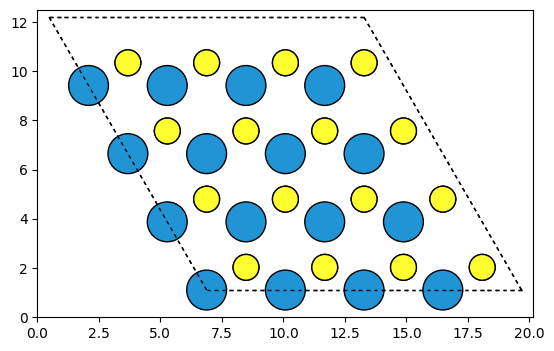

In [21]:
from ase.io import read
from ase.visualize import view
from ase.visualize.plot import plot_atoms

from io import StringIO

# Paste your structure text
poscar_str = """pred_atoms System
1.0
3.2 0.0 0.0
-1.6 2.77128 0.0
0.0 0.0 18.16
W S 
1 2 
direct
0.0 0.0 0.5 W
0.667 0.333 0.587 S
0.667 0.333 0.413 S
"""

# Read from string as POSCAR
atoms = read(StringIO(poscar_str), format='vasp')
atoms = atoms * (4,4,1)
fig, ax = plt.subplots()
plot_atoms(atoms, ax, radii=0.5, rotation=('0x, 0y, 0z'))
plt.show()


## trying on blank image